# **DATA LOADING AND NORMALIZATION**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 20.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [ ]:
from tqdm import tqdm
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224


def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)

        imgs = os.listdir(path)
        for img in tqdm(imgs):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image

                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")


    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/content/drive/MyDrive/normData/train')
test_data = get_training_data('/content/drive/MyDrive/normData/test')
val_data = get_training_data( '/content/drive/MyDrive/normData/val')

100%|██████████| 108/108 [00:02<00:00, 43.53it/s]


## **DATA Preparation**

Count of label 0: 3775
Count of label 1: 3775
Count of label 0: 108
Count of label 1: 108
Shape of train images: (7550, 224, 224)
Shape of validation images: (216, 224, 224)


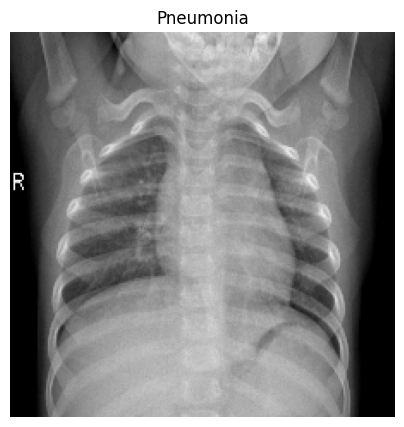

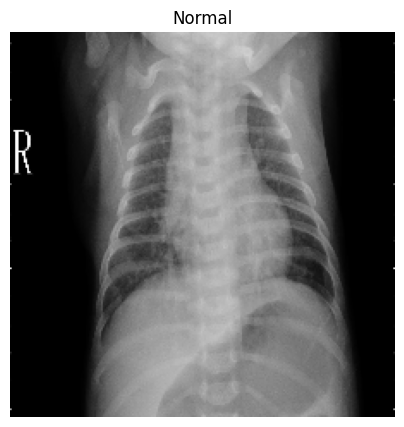

In [ ]:
#Separate the images and the labels
train_images_display = np.array([x[0] for x in train_data])  # Extract only the images
train_labels_display = np.array([x[1] for x in train_data])  # Extract only the labels

# Initialize counts for each label
count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in train_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

val_images_display = np.array([x[0] for x in val_data])  # Extract only the images
val_labels_display = np.array([x[1] for x in val_data])  # Extract only the labels

count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in val_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

test_images_display = np.array([x[0] for x in test_data])  # Extract only the images
test_labels_display = np.array([x[1] for x in test_data])  # Extract only the labels

# Check the shape and an example of the dataset
print(f"Shape of train images: {train_images_display.shape}")
print(f"Shape of validation images: {val_images_display.shape}")

# Display the first image from the training data
plt.figure(figsize=(5, 5))
plt.imshow(train_images_display[0], cmap='gray')
plt.title('Pneumonia' if train_labels_display[0] == 0 else 'Normal')
plt.axis('off')
plt.show()

# Display the last image from the validation data
plt.figure(figsize=(5, 5))
plt.imshow(val_images_display[-1], cmap='gray')
plt.title('Pneumonia' if val_labels_display[-1] == 0 else 'Normal')
plt.axis('off')
plt.show()

### Normalize Images

In [ ]:
# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []

    for img, label in tqdm(data):
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)

    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)


# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled test images: {test_images.shape}")
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

100%|██████████| 624/624 [00:00<00:00, 3189.14it/s]


Shape of normalized and shuffled test images: (624, 224, 224)
Shape of normalized and shuffled train images: (7550, 224, 224)
Shape of normalized and shuffled validation images: (216, 224, 224)


### Create Dataloaders

In [110]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the images and labels to PyTorch tensors

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in train_images]).unsqueeze(1)
train_images_tensor = torch.flatten(train_images_tensor, start_dim=2)
val_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in val_images]).unsqueeze(1)
val_images_tensor = torch.flatten(val_images_tensor, start_dim=2)
test_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in test_images]).unsqueeze(1)
test_images_tensor = torch.flatten(test_images_tensor, start_dim=2)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2)  # (N, 1, 244 x 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2)      # (N, 1, 244 x 244)
test_images_tensor = test_images_tensor.permute(0, 1, 2)    # (N, 1, 244 x 244)
print(train_images_tensor.shape, val_images_tensor.shape, test_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
print('Done!')

torch.Size([7550, 1, 50176]) torch.Size([216, 1, 50176]) torch.Size([624, 1, 50176])
Done!


<ipython-input-110-02f9a3f3256b>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels = torch.tensor(test_labels, dtype=torch.long)


### Efficient KAN

In [ ]:
class KANLinearEff(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinearEff, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class Eff_KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(Eff_KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(layers_hidden[0], layers_hidden[1]))
        self.layers.append(torch.nn.BatchNorm1d(1))
        self.layers.append(torch.nn.SiLU())
        for in_features, out_features in zip(layers_hidden[1:], layers_hidden[2:]):
            self.layers.append(
                KANLinearEff(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )




### Fourier KAN

In [ ]:
# Now the data is ready for training and validation
class NaiveFourierKANLayer(torch.nn.Module):
    def __init__(self, inputdim, outdim, initial_gridsize, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        # Learnable gridsize parameter
        self.gridsize_param = torch.nn.Parameter(torch.tensor(initial_gridsize, dtype=torch.float32))

        # Fourier coefficients as a learnable parameter with Xavier initialization
        self.fouriercoeffs = torch.nn.Parameter(torch.empty(2, outdim, inputdim, initial_gridsize))
        torch.nn.init.xavier_uniform_(self.fouriercoeffs)

        if self.addbias:
            self.bias = torch.nn.Parameter(torch.zeros(1, outdim))

    def forward(self, x):
        gridsize = torch.clamp(self.gridsize_param, min=1).round().int()
        xshp = x.shape
        outshape = xshp[:-1] + (self.outdim,)
        x = torch.reshape(x, (-1, self.inputdim))
        k = torch.reshape(torch.arange(1, gridsize + 1, device=x.device), (1, 1, 1, gridsize))
        xrshp = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        y = torch.sum(c * self.fouriercoeffs[0:1, :, :, :gridsize], (-2, -1))
        y += torch.sum(s * self.fouriercoeffs[1:2, :, :, :gridsize], (-2, -1))
        if self.addbias:
            y += self.bias
        y = torch.reshape(y, outshape)
        return y

class FourierKAN(torch.nn.Module):
    def __init__(self, params_list):
        super(FourierKAN, self).__init__()
        self.layer1 = torch.nn.Linear(params_list[0], params_list[1])
        torch.nn.init.xavier_uniform_(self.layer1.weight)
        self.bn1 = torch.nn.BatchNorm1d(1)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = NaiveFourierKANLayer(params_list[1], params_list[2], initial_gridsize=16)
        self.layer3 = NaiveFourierKANLayer(params_list[2], params_list[3], initial_gridsize=4)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x
model_str = "FourierKAN"



### Fast KAN

In [ ]:
from typing import List
class SplineLinear(torch.nn.Linear):
    def __init__(self, in_features: int, out_features: int, init_scale: float = 0.1, **kw) -> None:
        self.init_scale = init_scale
        super().__init__(in_features, out_features, bias=False, **kw)

    def reset_parameters(self) -> None:
        torch.nn.init.trunc_normal_(self.weight, mean=0, std=self.init_scale)

class RadialBasisFunction(torch.nn.Module):
    def __init__(
        self,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        denominator: float = None,  # larger denominators lead to smoother basis
    ):
        super().__init__()
        self.grid_min = grid_min
        self.grid_max = grid_max
        self.num_grids = num_grids
        grid = torch.linspace(grid_min, grid_max, num_grids)
        self.grid = torch.nn.Parameter(grid, requires_grad=False)
        self.denominator = denominator or (grid_max - grid_min) / (num_grids - 1)

    def forward(self, x):
        return torch.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(torch.nn.Module):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        use_layernorm: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.layernorm = None
        if use_layernorm:
            assert input_dim > 1, "Do not use layernorms on 1D inputs. Set `use_layernorm=False`."
            self.layernorm = torch.nn.LayerNorm(input_dim)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = SplineLinear(input_dim * num_grids, output_dim, spline_weight_init_scale)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x, use_layernorm=True):
        if self.layernorm is not None and use_layernorm:
            spline_basis = self.rbf(self.layernorm(x))
        else:
            spline_basis = self.rbf(x)
        ret = self.spline_linear(spline_basis.view(*spline_basis.shape[:-2], -1))
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

    def plot_curve(
        self,
        input_index: int,
        output_index: int,
        num_pts: int = 1000,
        num_extrapolate_bins: int = 2
    ):
        '''this function returns the learned curves in a FastKANLayer.
        input_index: the selected index of the input, in [0, input_dim) .
        output_index: the selected index of the output, in [0, output_dim) .
        num_pts: num of points sampled for the curve.
        num_extrapolate_bins (N_e): num of bins extrapolating from the given grids. The curve
            will be calculate in the range of [grid_min - h * N_e, grid_max + h * N_e].
        '''
        ng = self.rbf.num_grids
        h = self.rbf.denominator
        assert input_index < self.input_dim
        assert output_index < self.output_dim
        w = self.spline_linear.weight[
            output_index, input_index * ng : (input_index + 1) * ng
        ]   # num_grids,
        x = torch.linspace(
            self.rbf.grid_min - num_extrapolate_bins * h,
            self.rbf.grid_max + num_extrapolate_bins * h,
            num_pts
        )   # num_pts, num_grids
        with torch.no_grad():
            y = (w * self.rbf(x.to(w.dtype))).sum(-1)
        return x, y


class FastKAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden: List[int],
        grid_min: float = -2.,
        grid_max: float = 2.,
        num_grids: int = 8,
        use_base_update: bool = True,
        base_activation = F.silu,
        spline_weight_init_scale: float = 0.1,
    ) -> None:
        super().__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(layers_hidden[0], layers_hidden[1]))
        self.layers.append(torch.nn.BatchNorm1d(1))
        self.layers.append(torch.nn.SiLU())
        for in_features, out_features in zip(layers_hidden[1:], layers_hidden[2:]):
          self.layers.append(FastKANLayer(
                in_features, out_features,
                grid_min=grid_min,
                grid_max=grid_max,
                num_grids=num_grids,
                use_base_update=use_base_update,
                base_activation=base_activation,
                spline_weight_init_scale=spline_weight_init_scale,
            ))
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

### Linear KAN

In [ ]:
class KANLinear_v1(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear_v1, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h
                 + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1]
                     + (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x, y):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.spline_weight.view(self.out_features, -1)
        )
        return base_output + spline_output

class Linear_KAN(torch.nn.Module):
    def __init__(self, parameters_list):
        super(Linear_KAN, self).__init__()
        self.layer1 = torch.nn.Linear(parameters_list[0], parameters_list[1])
        self.bn1 = torch.nn.BatchNorm1d(1)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = KANLinear_v1(parameters_list[1], parameters_list[2], grid_size=16)
        self.layer3 = KANLinear_v1(parameters_list[2], parameters_list[3], grid_size=16)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x

### KAN KAL

In [ ]:
import torch.nn as nn
from functools import lru_cache
class KAL_Net(nn.Module):
    def __init__(self, layers_hidden, polynomial_order=3, base_activation=nn.SiLU, dropout_prob=0.5):
        super(KAL_Net, self).__init__()
        self.layers_hidden = layers_hidden
        self.polynomial_order = polynomial_order
        self.base_activation = base_activation()
        self.dropout_prob = dropout_prob

        self.base_weights = nn.ParameterList()
        self.poly_weights = nn.ParameterList()
        self.layer_norms = nn.ModuleList()

        # Define layers based on the provided hidden layers structure
        for in_features, out_features in zip(layers_hidden[:-2], layers_hidden[1:-1]):
            self.base_weights.append(nn.Parameter(torch.randn(out_features, in_features)))
            self.poly_weights.append(nn.Parameter(torch.randn(out_features, in_features * (polynomial_order + 1))))
            self.layer_norms.append(nn.LayerNorm(out_features))

        # Dropout Layers
        self.dropouts = nn.ModuleList([nn.Dropout(p=dropout_prob) for _ in self.layer_norms])

        # Output layer for binary classification
        self.output_layer = nn.Linear(layers_hidden[-2], layers_hidden[-1])

        for weight in self.base_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        if order == 0:
            return P0.unsqueeze(-1)
        P1 = x
        legendre_polys = [P0, P1]

        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)

        return torch.stack(legendre_polys, dim=-1)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)  # Flatten the input correctly to match the input size of 22500

        for base_weight, poly_weight, layer_norm, dropout in zip(self.base_weights, self.poly_weights, self.layer_norms, self.dropouts):
            base_output = F.linear(self.base_activation(x), base_weight)

            x_normalized = 2 * (x - x.min()) / (x.max() - x.min()) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized, self.polynomial_order)
            legendre_basis = legendre_basis.view(batch_size, -1)

            poly_output = F.linear(legendre_basis, poly_weight)
            x = self.base_activation(layer_norm(base_output + poly_output))
            x = dropout(x)

        x = self.output_layer(x)
        return torch.softmax(x, dim=1)  # Use softmax for multi-class classification

### KAN Real

In [ ]:
class Real_Net(nn.Module):
    def __init__(self, input_dims, polynomial_order=3, activation=nn.ReLU):
        super(Real_Net, self).__init__()
        input_dim = input_dims[0]
        hidden_dim = input_dims[1:-1]
        output_dim = input_dims[-1]
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.polynomial_order = polynomial_order
        self.activation = activation()

        poly_feature_size = (self.polynomial_order + 1) * self.input_dim

        self.base_layers = nn.ModuleList()
        in_dim = self.input_dim
        for dim in hidden_dim:
            self.base_layers.append(nn.Linear(in_dim, dim))
            in_dim = dim

        self.poly_weights = nn.ParameterList([
            nn.Parameter(torch.randn(dim, poly_feature_size)) for dim in hidden_dim
        ])

        self.output_layer = nn.Linear(in_dim, output_dim)

        for layer in self.base_layers:
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        for weight in self.poly_weights:
            nn.init.kaiming_uniform_(weight, nonlinearity='linear')

    @staticmethod
    def compute_legendre_polynomials(x, order):
        P0 = torch.ones_like(x)
        P1 = x
        legendre_polys = [P0, P1]

        for n in range(1, order):
            Pn = ((2.0 * n + 1.0) * x * legendre_polys[-1] - n * legendre_polys[-2]) / (n + 1.0)
            legendre_polys.append(Pn)

        return torch.cat(legendre_polys, dim=-1)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        for layer, poly_weight in zip(self.base_layers, self.poly_weights):
            base_output = self.activation(layer(x))

            x_min = x.min(dim=1, keepdim=True)[0]
            x_max = x.max(dim=1, keepdim=True)[0]
            x_normalized = 2 * (x - x_min) / (x_max - x_min) - 1
            legendre_basis = self.compute_legendre_polynomials(x_normalized.unsqueeze(-1), self.polynomial_order)

            legendre_basis = legendre_basis.view(x.size(0), -1)  # Reshape to match poly_weight expectations

            # Adjust the dimension of the Legendre basis to match the poly_weight dimension
            if legendre_basis.shape[1] != poly_weight.shape[1]:
                legendre_basis = F.interpolate(legendre_basis.unsqueeze(1), size=(poly_weight.shape[1],), mode='linear', align_corners=False).squeeze(1)

            poly_output = torch.matmul(legendre_basis, poly_weight.T)
            x = self.activation(base_output + poly_output)

        x = self.output_layer(x)
        return x



In [ ]:
model = KAL_Net([224 * 224, 224, 128, 2])
#model = Real_Net([224*224, 224, 128, 2])
#model = Linear_KAN([224*224, 224, 128, 2])
#model = FastKAN([224*224, 224, 128, 2])
#model = FourierKAN([224*224, 224, 128, 2])
#model = Eff_KAN([224*224, 224, 128, 2])

[50176, 224, 128, 2] 128 2


In [104]:
# Define model
models = [[Real_Net, 'REAL_NET'],[KAL_Net, 'KAL_NET'], [Linear_KAN, 'LINEAR_NET'], [FastKAN, 'FAST_NET'],[FourierKAN, 'FOURIER_NET'],[Eff_KAN, 'EFF_NET']]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


Start training of: REAL_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 143.43it/s]


Epoch 1/100 - Validation F1 Score: 0.8199 - Validation Recall Score: 0.6993 - Validation Precision Score: 0.9907
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.13it/s]


Epoch 2/100 - Validation F1 Score: 0.9145 - Validation Recall Score: 0.8492 - Validation Precision Score: 0.9907
Exceeded


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.64it/s]


Epoch 3/100 - Validation F1 Score: 0.9333 - Validation Recall Score: 0.9608 - Validation Precision Score: 0.9074
Exceeded


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.98it/s]


Epoch 4/100 - Validation F1 Score: 0.9417 - Validation Recall Score: 0.9130 - Validation Precision Score: 0.9722
Exceeded


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.12it/s]


Epoch 5/100 - Validation F1 Score: 0.8962 - Validation Recall Score: 0.8120 - Validation Precision Score: 1.0000


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.15it/s]


Epoch 6/100 - Validation F1 Score: 0.9533 - Validation Recall Score: 0.9623 - Validation Precision Score: 0.9444
Exceeded


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.54it/s]


Epoch 7/100 - Validation F1 Score: 0.9100 - Validation Recall Score: 0.9891 - Validation Precision Score: 0.8426


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.91it/s]


Epoch 8/100 - Validation F1 Score: 0.9589 - Validation Recall Score: 0.9459 - Validation Precision Score: 0.9722
Exceeded


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.34it/s]


Epoch 9/100 - Validation F1 Score: 0.9577 - Validation Recall Score: 0.9714 - Validation Precision Score: 0.9444


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.89it/s]


Epoch 10/100 - Validation F1 Score: 0.9626 - Validation Recall Score: 0.9717 - Validation Precision Score: 0.9537
Exceeded


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.36it/s]


Epoch 11/100 - Validation F1 Score: 0.9770 - Validation Recall Score: 0.9725 - Validation Precision Score: 0.9815
Exceeded


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.73it/s]


Epoch 12/100 - Validation F1 Score: 0.9639 - Validation Recall Score: 0.9386 - Validation Precision Score: 0.9907


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 131.72it/s]


Epoch 13/100 - Validation F1 Score: 0.9574 - Validation Recall Score: 0.9806 - Validation Precision Score: 0.9352


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.87it/s]


Epoch 14/100 - Validation F1 Score: 0.9727 - Validation Recall Score: 0.9554 - Validation Precision Score: 0.9907


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.13it/s]


Epoch 15/100 - Validation F1 Score: 0.9770 - Validation Recall Score: 0.9725 - Validation Precision Score: 0.9815


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.85it/s]


Epoch 16/100 - Validation F1 Score: 0.9672 - Validation Recall Score: 0.9810 - Validation Precision Score: 0.9537


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.28it/s]


Epoch 17/100 - Validation F1 Score: 0.9596 - Validation Recall Score: 0.9304 - Validation Precision Score: 0.9907


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.22it/s]


Epoch 18/100 - Validation F1 Score: 0.9725 - Validation Recall Score: 0.9636 - Validation Precision Score: 0.9815


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.05it/s]


Epoch 19/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907
Exceeded


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 141.62it/s]


Epoch 20/100 - Validation F1 Score: 0.9722 - Validation Recall Score: 0.9722 - Validation Precision Score: 0.9722


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.52it/s]


Epoch 21/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.65it/s]


Epoch 22/100 - Validation F1 Score: 0.9677 - Validation Recall Score: 0.9633 - Validation Precision Score: 0.9722


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.56it/s]


Epoch 23/100 - Validation F1 Score: 0.9727 - Validation Recall Score: 0.9554 - Validation Precision Score: 0.9907


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 146.18it/s]


Epoch 24/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 149.82it/s]


Epoch 25/100 - Validation F1 Score: 0.9725 - Validation Recall Score: 0.9636 - Validation Precision Score: 0.9815


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.26it/s]


Epoch 26/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.92it/s]


Epoch 27/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.13it/s]


Epoch 28/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.59it/s]


Epoch 29/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.28it/s]


Epoch 30/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.59it/s]


Epoch 31/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 135.53it/s]


Epoch 32/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.79it/s]


Epoch 33/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.55it/s]


Epoch 34/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.71it/s]


Epoch 35/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.60it/s]


Epoch 36/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.43it/s]


Epoch 37/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.58it/s]


Epoch 38/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 148.74it/s]


Epoch 39/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.22it/s]


Epoch 40/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.40it/s]


Epoch 41/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.15it/s]


Epoch 42/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.11it/s]


Epoch 43/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.82it/s]


Epoch 44/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.78it/s]


Epoch 45/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 136.40it/s]


Epoch 46/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.87it/s]


Epoch 47/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.15it/s]


Epoch 48/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.49it/s]


Epoch 49/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.36it/s]


Epoch 50/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.61it/s]


Epoch 51/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.73it/s]


Epoch 52/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.94it/s]


Epoch 53/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 146.94it/s]


Epoch 54/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.67it/s]


Epoch 55/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.88it/s]


Epoch 56/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.67it/s]


Epoch 57/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.53it/s]


Epoch 58/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.10it/s]


Epoch 59/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.53it/s]


Epoch 60/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 142.59it/s]


Epoch 61/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.53it/s]


Epoch 62/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.09it/s]


Epoch 63/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.44it/s]


Epoch 64/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.39it/s]


Epoch 65/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.87it/s]


Epoch 66/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.26it/s]


Epoch 67/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 147.38it/s]


Epoch 68/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.25it/s]


Epoch 69/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.59it/s]


Epoch 70/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.23it/s]


Epoch 71/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.81it/s]


Epoch 72/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.36it/s]


Epoch 73/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.08it/s]


Epoch 74/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.34it/s]


Epoch 75/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 128.74it/s]


Epoch 76/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.51it/s]


Epoch 77/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.42it/s]


Epoch 78/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.79it/s]


Epoch 79/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.76it/s]


Epoch 80/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.70it/s]


Epoch 81/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.44it/s]


Epoch 82/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.81it/s]


Epoch 83/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.42it/s]


Epoch 84/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.69it/s]


Epoch 85/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.02it/s]


Epoch 86/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.56it/s]


Epoch 87/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.59it/s]


Epoch 88/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.65it/s]


Epoch 89/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.55it/s]


Epoch 90/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 140.09it/s]


Epoch 91/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.07it/s]


Epoch 92/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.88it/s]


Epoch 93/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.24it/s]


Epoch 94/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.56it/s]


Epoch 95/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.80it/s]


Epoch 96/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 129.79it/s]


Epoch 97/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.42it/s]


Epoch 98/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.42it/s]


Epoch 99/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.38it/s]


Epoch 100/100 - Validation F1 Score: 0.9772 - Validation Recall Score: 0.9640 - Validation Precision Score: 0.9907
Best F1: 0.9772, Precision: 0.9907, Recall: 0.964




Start training of: KAL_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.15it/s]


Epoch 1/100 - Validation F1 Score: 0.8320 - Validation Recall Score: 0.7324 - Validation Precision Score: 0.9630
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.48it/s]


Epoch 2/100 - Validation F1 Score: 0.8615 - Validation Recall Score: 0.9655 - Validation Precision Score: 0.7778
Exceeded


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.96it/s]


Epoch 3/100 - Validation F1 Score: 0.8955 - Validation Recall Score: 0.9677 - Validation Precision Score: 0.8333
Exceeded


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.70it/s]


Epoch 4/100 - Validation F1 Score: 0.8942 - Validation Recall Score: 0.9300 - Validation Precision Score: 0.8611


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.10it/s]


Epoch 5/100 - Validation F1 Score: 0.9167 - Validation Recall Score: 0.9167 - Validation Precision Score: 0.9167
Exceeded


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.31it/s]


Epoch 6/100 - Validation F1 Score: 0.8990 - Validation Recall Score: 0.9889 - Validation Precision Score: 0.8241


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.84it/s]


Epoch 7/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444
Exceeded


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.68it/s]


Epoch 8/100 - Validation F1 Score: 0.9384 - Validation Recall Score: 0.9612 - Validation Precision Score: 0.9167
Exceeded


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.78it/s]


Epoch 9/100 - Validation F1 Score: 0.9302 - Validation Recall Score: 0.9346 - Validation Precision Score: 0.9259


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.91it/s]


Epoch 10/100 - Validation F1 Score: 0.9216 - Validation Recall Score: 0.9792 - Validation Precision Score: 0.8704


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.42it/s]


Epoch 11/100 - Validation F1 Score: 0.9216 - Validation Recall Score: 0.9174 - Validation Precision Score: 0.9259


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 185.65it/s]


Epoch 12/100 - Validation F1 Score: 0.9194 - Validation Recall Score: 0.9417 - Validation Precision Score: 0.8981


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.49it/s]


Epoch 13/100 - Validation F1 Score: 0.9346 - Validation Recall Score: 0.9434 - Validation Precision Score: 0.9259


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.43it/s]


Epoch 14/100 - Validation F1 Score: 0.9434 - Validation Recall Score: 0.9615 - Validation Precision Score: 0.9259
Exceeded


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.73it/s]


Epoch 15/100 - Validation F1 Score: 0.9484 - Validation Recall Score: 0.9619 - Validation Precision Score: 0.9352
Exceeded


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.47it/s]


Epoch 16/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.99it/s]


Epoch 17/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.46it/s]


Epoch 18/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.51it/s]


Epoch 19/100 - Validation F1 Score: 0.9358 - Validation Recall Score: 0.9273 - Validation Precision Score: 0.9444


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.44it/s]


Epoch 20/100 - Validation F1 Score: 0.9439 - Validation Recall Score: 0.9528 - Validation Precision Score: 0.9352


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.81it/s]


Epoch 21/100 - Validation F1 Score: 0.9434 - Validation Recall Score: 0.9615 - Validation Precision Score: 0.9259


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.90it/s]


Epoch 22/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.18it/s]


Epoch 23/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444
Exceeded


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.40it/s]


Epoch 24/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.33it/s]


Epoch 25/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.25it/s]


Epoch 26/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 201.95it/s]


Epoch 27/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.79it/s]


Epoch 28/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 197.00it/s]


Epoch 29/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.34it/s]


Epoch 30/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.51it/s]


Epoch 31/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.72it/s]


Epoch 32/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.13it/s]


Epoch 33/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.86it/s]


Epoch 34/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.40it/s]


Epoch 35/100 - Validation F1 Score: 0.9484 - Validation Recall Score: 0.9619 - Validation Precision Score: 0.9352


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 143.77it/s]


Epoch 36/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.92it/s]


Epoch 37/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.28it/s]


Epoch 38/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.80it/s]


Epoch 39/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.45it/s]


Epoch 40/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.74it/s]


Epoch 41/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.11it/s]


Epoch 42/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 185.99it/s]


Epoch 43/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.46it/s]


Epoch 44/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.45it/s]


Epoch 45/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.57it/s]


Epoch 46/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.64it/s]


Epoch 47/100 - Validation F1 Score: 0.9493 - Validation Recall Score: 0.9450 - Validation Precision Score: 0.9537
Exceeded


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.50it/s]


Epoch 48/100 - Validation F1 Score: 0.9493 - Validation Recall Score: 0.9450 - Validation Precision Score: 0.9537


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.56it/s]


Epoch 49/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.09it/s]


Epoch 50/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.84it/s]


Epoch 51/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.18it/s]


Epoch 52/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.05it/s]


Epoch 53/100 - Validation F1 Score: 0.9439 - Validation Recall Score: 0.9528 - Validation Precision Score: 0.9352


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.89it/s]


Epoch 54/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.18it/s]


Epoch 55/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.21it/s]


Epoch 56/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.03it/s]


Epoch 57/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.62it/s]


Epoch 58/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.76it/s]


Epoch 59/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.35it/s]


Epoch 60/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.46it/s]


Epoch 61/100 - Validation F1 Score: 0.9346 - Validation Recall Score: 0.9434 - Validation Precision Score: 0.9259


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.27it/s]


Epoch 62/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.70it/s]


Epoch 63/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.44it/s]


Epoch 64/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.39it/s]


Epoch 65/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.03it/s]


Epoch 66/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.10it/s]


Epoch 67/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.68it/s]


Epoch 68/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.73it/s]


Epoch 69/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.48it/s]


Epoch 70/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.45it/s]


Epoch 71/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.26it/s]


Epoch 72/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.93it/s]


Epoch 73/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.08it/s]


Epoch 74/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.89it/s]


Epoch 75/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.04it/s]


Epoch 76/100 - Validation F1 Score: 0.9346 - Validation Recall Score: 0.9434 - Validation Precision Score: 0.9259


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 185.68it/s]


Epoch 77/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.02it/s]


Epoch 78/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 140.30it/s]


Epoch 79/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.60it/s]


Epoch 80/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.09it/s]


Epoch 81/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.80it/s]


Epoch 82/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.50it/s]


Epoch 83/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.32it/s]


Epoch 84/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.06it/s]


Epoch 85/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.45it/s]


Epoch 86/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.47it/s]


Epoch 87/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.40it/s]


Epoch 88/100 - Validation F1 Score: 0.9309 - Validation Recall Score: 0.9266 - Validation Precision Score: 0.9352


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.49it/s]


Epoch 89/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.20it/s]


Epoch 90/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.57it/s]


Epoch 91/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 194.99it/s]


Epoch 92/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.43it/s]


Epoch 93/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.82it/s]


Epoch 94/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.08it/s]


Epoch 95/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.68it/s]


Epoch 96/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.95it/s]


Epoch 97/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.26it/s]


Epoch 98/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 202.77it/s]


Epoch 99/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.75it/s]


Epoch 100/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444
Best F1: 0.9493, Precision: 0.9537, Recall: 0.945




Start training of: LINEAR_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.07it/s]


Epoch 1/100 - Validation F1 Score: 0.8123 - Validation Recall Score: 0.6928 - Validation Precision Score: 0.9815
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.69it/s]


Epoch 2/100 - Validation F1 Score: 0.8557 - Validation Recall Score: 0.9247 - Validation Precision Score: 0.7963
Exceeded


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.65it/s]


Epoch 3/100 - Validation F1 Score: 0.8848 - Validation Recall Score: 0.8807 - Validation Precision Score: 0.8889
Exceeded


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.70it/s]


Epoch 4/100 - Validation F1 Score: 0.8015 - Validation Recall Score: 0.6730 - Validation Precision Score: 0.9907


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.05it/s]


Epoch 5/100 - Validation F1 Score: 0.8425 - Validation Recall Score: 0.7329 - Validation Precision Score: 0.9907


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 146.59it/s]


Epoch 6/100 - Validation F1 Score: 0.8878 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.8426
Exceeded


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.42it/s]


Epoch 7/100 - Validation F1 Score: 0.9210 - Validation Recall Score: 0.8750 - Validation Precision Score: 0.9722
Exceeded


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.49it/s]


Epoch 8/100 - Validation F1 Score: 0.9286 - Validation Recall Score: 0.8966 - Validation Precision Score: 0.9630
Exceeded


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.52it/s]


Epoch 9/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.17it/s]


Epoch 10/100 - Validation F1 Score: 0.9302 - Validation Recall Score: 0.9346 - Validation Precision Score: 0.9259
Exceeded


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.64it/s]


Epoch 11/100 - Validation F1 Score: 0.9083 - Validation Recall Score: 0.9000 - Validation Precision Score: 0.9167


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.66it/s]


Epoch 12/100 - Validation F1 Score: 0.9333 - Validation Recall Score: 0.8974 - Validation Precision Score: 0.9722
Exceeded


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.89it/s]


Epoch 13/100 - Validation F1 Score: 0.8594 - Validation Recall Score: 0.7589 - Validation Precision Score: 0.9907


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.03it/s]


Epoch 14/100 - Validation F1 Score: 0.9352 - Validation Recall Score: 0.9352 - Validation Precision Score: 0.9352
Exceeded


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.53it/s]


Epoch 15/100 - Validation F1 Score: 0.9395 - Validation Recall Score: 0.9439 - Validation Precision Score: 0.9352
Exceeded


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.38it/s]


Epoch 16/100 - Validation F1 Score: 0.9333 - Validation Recall Score: 0.8974 - Validation Precision Score: 0.9722


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.83it/s]


Epoch 17/100 - Validation F1 Score: 0.9216 - Validation Recall Score: 0.9174 - Validation Precision Score: 0.9259


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.64it/s]


Epoch 18/100 - Validation F1 Score: 0.9309 - Validation Recall Score: 0.9266 - Validation Precision Score: 0.9352


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.21it/s]


Epoch 19/100 - Validation F1 Score: 0.9358 - Validation Recall Score: 0.9273 - Validation Precision Score: 0.9444


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.79it/s]


Epoch 20/100 - Validation F1 Score: 0.9358 - Validation Recall Score: 0.9273 - Validation Precision Score: 0.9444


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.92it/s]


Epoch 21/100 - Validation F1 Score: 0.9358 - Validation Recall Score: 0.9273 - Validation Precision Score: 0.9444


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.44it/s]


Epoch 22/100 - Validation F1 Score: 0.9381 - Validation Recall Score: 0.8983 - Validation Precision Score: 0.9815


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 143.04it/s]


Epoch 23/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.56it/s]


Epoch 24/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 140.63it/s]


Epoch 25/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.44it/s]


Epoch 26/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.26it/s]


Epoch 27/100 - Validation F1 Score: 0.9358 - Validation Recall Score: 0.9273 - Validation Precision Score: 0.9444


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 142.23it/s]


Epoch 28/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 146.05it/s]


Epoch 29/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.60it/s]


Epoch 30/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.88it/s]


Epoch 31/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.31it/s]


Epoch 32/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.47it/s]


Epoch 33/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.80it/s]


Epoch 34/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 92.61it/s]


Epoch 35/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.41it/s]


Epoch 36/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.21it/s]


Epoch 37/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.12it/s]


Epoch 38/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.16it/s]


Epoch 39/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.33it/s]


Epoch 40/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.51it/s]


Epoch 41/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.75it/s]


Epoch 42/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.66it/s]


Epoch 43/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.76it/s]


Epoch 44/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.00it/s]


Epoch 45/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.29it/s]


Epoch 46/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 111.92it/s]


Epoch 47/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.26it/s]


Epoch 48/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.63it/s]


Epoch 49/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.26it/s]


Epoch 50/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 129.74it/s]


Epoch 51/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.18it/s]


Epoch 52/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 148.02it/s]


Epoch 53/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.95it/s]


Epoch 54/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.07it/s]


Epoch 55/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.81it/s]


Epoch 56/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.34it/s]


Epoch 57/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.05it/s]


Epoch 58/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.40it/s]


Epoch 59/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.53it/s]


Epoch 60/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.13it/s]


Epoch 61/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 136.22it/s]


Epoch 62/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.00it/s]


Epoch 63/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.99it/s]


Epoch 64/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.59it/s]


Epoch 65/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.12it/s]


Epoch 66/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.48it/s]


Epoch 67/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.80it/s]


Epoch 68/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.58it/s]


Epoch 69/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 129.17it/s]


Epoch 70/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 147.44it/s]


Epoch 71/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.51it/s]


Epoch 72/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.81it/s]


Epoch 73/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.60it/s]


Epoch 74/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.64it/s]


Epoch 75/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 136.22it/s]


Epoch 76/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.46it/s]


Epoch 77/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.61it/s]


Epoch 78/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.96it/s]


Epoch 79/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 185.36it/s]


Epoch 80/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 134.27it/s]


Epoch 81/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.59it/s]


Epoch 82/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.13it/s]


Epoch 83/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.42it/s]


Epoch 84/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.51it/s]


Epoch 85/100 - Validation F1 Score: 0.9279 - Validation Recall Score: 0.9035 - Validation Precision Score: 0.9537


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.26it/s]


Epoch 86/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 154.36it/s]


Epoch 87/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.07it/s]


Epoch 88/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.39it/s]


Epoch 89/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.01it/s]


Epoch 90/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.84it/s]


Epoch 91/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.92it/s]


Epoch 92/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 132.27it/s]


Epoch 93/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.41it/s]


Epoch 94/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 149.27it/s]


Epoch 95/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.37it/s]


Epoch 96/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 124.65it/s]


Epoch 97/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 148.39it/s]


Epoch 98/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.80it/s]


Epoch 99/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 139.90it/s]


Epoch 100/100 - Validation F1 Score: 0.9272 - Validation Recall Score: 0.9107 - Validation Precision Score: 0.9444
Best F1: 0.9395, Precision: 0.9352, Recall: 0.9439




Start training of: FAST_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.33it/s]


Epoch 1/100 - Validation F1 Score: 0.7826 - Validation Recall Score: 0.6429 - Validation Precision Score: 1.0000
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 215.22it/s]


Epoch 2/100 - Validation F1 Score: 0.7059 - Validation Recall Score: 0.5455 - Validation Precision Score: 1.0000


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 233.39it/s]


Epoch 3/100 - Validation F1 Score: 0.8839 - Validation Recall Score: 0.8534 - Validation Precision Score: 0.9167
Exceeded


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.01it/s]


Epoch 4/100 - Validation F1 Score: 0.8316 - Validation Recall Score: 0.9634 - Validation Precision Score: 0.7315


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.88it/s]


Epoch 5/100 - Validation F1 Score: 0.8123 - Validation Recall Score: 0.6928 - Validation Precision Score: 0.9815


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 237.04it/s]


Epoch 6/100 - Validation F1 Score: 0.9075 - Validation Recall Score: 0.8655 - Validation Precision Score: 0.9537
Exceeded


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.39it/s]


Epoch 7/100 - Validation F1 Score: 0.9083 - Validation Recall Score: 0.8595 - Validation Precision Score: 0.9630
Exceeded


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.41it/s]


Epoch 8/100 - Validation F1 Score: 0.8776 - Validation Recall Score: 0.9773 - Validation Precision Score: 0.7963


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 227.96it/s]


Epoch 9/100 - Validation F1 Score: 0.9279 - Validation Recall Score: 0.9035 - Validation Precision Score: 0.9537
Exceeded


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.02it/s]


Epoch 10/100 - Validation F1 Score: 0.9333 - Validation Recall Score: 0.8974 - Validation Precision Score: 0.9722
Exceeded


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.75it/s]


Epoch 11/100 - Validation F1 Score: 0.9488 - Validation Recall Score: 0.9533 - Validation Precision Score: 0.9444
Exceeded


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 208.54it/s]


Epoch 12/100 - Validation F1 Score: 0.9444 - Validation Recall Score: 0.9444 - Validation Precision Score: 0.9444


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.67it/s]


Epoch 13/100 - Validation F1 Score: 0.9187 - Validation Recall Score: 0.9505 - Validation Precision Score: 0.8889


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 228.58it/s]


Epoch 14/100 - Validation F1 Score: 0.9259 - Validation Recall Score: 0.9259 - Validation Precision Score: 0.9259


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 217.04it/s]


Epoch 15/100 - Validation F1 Score: 0.9279 - Validation Recall Score: 0.9035 - Validation Precision Score: 0.9537


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.20it/s]


Epoch 16/100 - Validation F1 Score: 0.9352 - Validation Recall Score: 0.9352 - Validation Precision Score: 0.9352


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.74it/s]


Epoch 17/100 - Validation F1 Score: 0.9204 - Validation Recall Score: 0.8814 - Validation Precision Score: 0.9630


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 215.64it/s]


Epoch 18/100 - Validation F1 Score: 0.9210 - Validation Recall Score: 0.8750 - Validation Precision Score: 0.9722


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.91it/s]


Epoch 19/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 228.40it/s]


Epoch 20/100 - Validation F1 Score: 0.9406 - Validation Recall Score: 0.9279 - Validation Precision Score: 0.9537


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 202.99it/s]


Epoch 21/100 - Validation F1 Score: 0.9401 - Validation Recall Score: 0.9358 - Validation Precision Score: 0.9444


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 223.46it/s]


Epoch 22/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.47it/s]


Epoch 23/100 - Validation F1 Score: 0.9450 - Validation Recall Score: 0.9364 - Validation Precision Score: 0.9537


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 195.02it/s]


Epoch 24/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.59it/s]


Epoch 25/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.79it/s]


Epoch 26/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 220.95it/s]


Epoch 27/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 201.13it/s]


Epoch 28/100 - Validation F1 Score: 0.9245 - Validation Recall Score: 0.8889 - Validation Precision Score: 0.9630


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.53it/s]


Epoch 29/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 238.93it/s]


Epoch 30/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 224.79it/s]


Epoch 31/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 204.13it/s]


Epoch 32/100 - Validation F1 Score: 0.9406 - Validation Recall Score: 0.9279 - Validation Precision Score: 0.9537


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 195.82it/s]


Epoch 33/100 - Validation F1 Score: 0.9406 - Validation Recall Score: 0.9279 - Validation Precision Score: 0.9537


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.79it/s]


Epoch 34/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 227.37it/s]


Epoch 35/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 216.87it/s]


Epoch 36/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 225.47it/s]


Epoch 37/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.51it/s]


Epoch 38/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 210.01it/s]


Epoch 39/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.45it/s]


Epoch 40/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 219.93it/s]


Epoch 41/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 202.14it/s]


Epoch 42/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 220.84it/s]


Epoch 43/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 231.48it/s]


Epoch 44/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.54it/s]


Epoch 45/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 215.43it/s]


Epoch 46/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 226.56it/s]


Epoch 47/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 205.86it/s]


Epoch 48/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.05it/s]


Epoch 49/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 199.81it/s]


Epoch 50/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 232.63it/s]


Epoch 51/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.88it/s]


Epoch 52/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 211.32it/s]


Epoch 53/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 222.28it/s]


Epoch 54/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 225.13it/s]


Epoch 55/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 227.60it/s]


Epoch 56/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 235.03it/s]


Epoch 57/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 225.58it/s]


Epoch 58/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 234.39it/s]


Epoch 59/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 222.78it/s]


Epoch 60/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.82it/s]


Epoch 61/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 236.92it/s]


Epoch 62/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 223.94it/s]


Epoch 63/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 214.78it/s]


Epoch 64/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.86it/s]


Epoch 65/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 225.99it/s]


Epoch 66/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.61it/s]


Epoch 67/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 223.85it/s]


Epoch 68/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 248.11it/s]


Epoch 69/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 202.05it/s]


Epoch 70/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 221.16it/s]


Epoch 71/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.29it/s]


Epoch 72/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 220.78it/s]


Epoch 73/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 202.94it/s]


Epoch 74/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.30it/s]


Epoch 75/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.90it/s]


Epoch 76/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.33it/s]


Epoch 77/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 222.87it/s]


Epoch 78/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 249.40it/s]


Epoch 79/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 232.06it/s]


Epoch 80/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.64it/s]


Epoch 81/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.36it/s]


Epoch 82/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 233.21it/s]


Epoch 83/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 195.72it/s]


Epoch 84/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 221.22it/s]


Epoch 85/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.48it/s]


Epoch 86/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 233.53it/s]


Epoch 87/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 199.58it/s]


Epoch 88/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 219.95it/s]


Epoch 89/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 194.14it/s]


Epoch 90/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 200.89it/s]


Epoch 91/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.62it/s]


Epoch 92/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 248.32it/s]


Epoch 93/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.94it/s]


Epoch 94/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.19it/s]


Epoch 95/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 220.31it/s]


Epoch 96/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 218.91it/s]


Epoch 97/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.20it/s]


Epoch 98/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 181.30it/s]


Epoch 99/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.98it/s]


Epoch 100/100 - Validation F1 Score: 0.9363 - Validation Recall Score: 0.9196 - Validation Precision Score: 0.9537
Best F1: 0.9488, Precision: 0.9444, Recall: 0.9533




Start training of: FOURIER_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.50it/s]


Epoch 1/100 - Validation F1 Score: 0.5283 - Validation Recall Score: 0.4459 - Validation Precision Score: 0.6481
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.49it/s]


Epoch 2/100 - Validation F1 Score: 0.5434 - Validation Recall Score: 0.4586 - Validation Precision Score: 0.6667
Exceeded


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.70it/s]


Epoch 3/100 - Validation F1 Score: 0.6930 - Validation Recall Score: 0.6583 - Validation Precision Score: 0.7315
Exceeded


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 186.94it/s]


Epoch 4/100 - Validation F1 Score: 0.8182 - Validation Recall Score: 0.7388 - Validation Precision Score: 0.9167
Exceeded


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 205.19it/s]


Epoch 5/100 - Validation F1 Score: 0.8633 - Validation Recall Score: 0.8016 - Validation Precision Score: 0.9352
Exceeded


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.86it/s]


Epoch 6/100 - Validation F1 Score: 0.8560 - Validation Recall Score: 0.7704 - Validation Precision Score: 0.9630


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.85it/s]


Epoch 7/100 - Validation F1 Score: 0.8327 - Validation Recall Score: 0.7181 - Validation Precision Score: 0.9907


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.05it/s]


Epoch 8/100 - Validation F1 Score: 0.9035 - Validation Recall Score: 0.8583 - Validation Precision Score: 0.9537
Exceeded


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 208.04it/s]


Epoch 9/100 - Validation F1 Score: 0.8812 - Validation Recall Score: 0.9468 - Validation Precision Score: 0.8241


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.82it/s]


Epoch 10/100 - Validation F1 Score: 0.9163 - Validation Recall Score: 0.8739 - Validation Precision Score: 0.9630
Exceeded


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.63it/s]


Epoch 11/100 - Validation F1 Score: 0.8966 - Validation Recall Score: 0.8387 - Validation Precision Score: 0.9630


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.44it/s]


Epoch 12/100 - Validation F1 Score: 0.8560 - Validation Recall Score: 0.7535 - Validation Precision Score: 0.9907


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 209.04it/s]


Epoch 13/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630
Exceeded


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 177.46it/s]


Epoch 14/100 - Validation F1 Score: 0.9060 - Validation Recall Score: 0.8413 - Validation Precision Score: 0.9815


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 208.61it/s]


Epoch 15/100 - Validation F1 Score: 0.9321 - Validation Recall Score: 0.9115 - Validation Precision Score: 0.9537


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.80it/s]


Epoch 16/100 - Validation F1 Score: 0.9163 - Validation Recall Score: 0.8739 - Validation Precision Score: 0.9630


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 195.63it/s]


Epoch 17/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9700 - Validation Precision Score: 0.8981


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.86it/s]


Epoch 18/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630
Exceeded


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.56it/s]


Epoch 19/100 - Validation F1 Score: 0.9298 - Validation Recall Score: 0.8833 - Validation Precision Score: 0.9815


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.87it/s]


Epoch 20/100 - Validation F1 Score: 0.9145 - Validation Recall Score: 0.8492 - Validation Precision Score: 0.9907


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 221.09it/s]


Epoch 21/100 - Validation F1 Score: 0.9245 - Validation Recall Score: 0.8889 - Validation Precision Score: 0.9630


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 225.01it/s]


Epoch 22/100 - Validation F1 Score: 0.9286 - Validation Recall Score: 0.8966 - Validation Precision Score: 0.9630


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 231.24it/s]


Epoch 23/100 - Validation F1 Score: 0.9245 - Validation Recall Score: 0.8889 - Validation Precision Score: 0.9630


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.44it/s]


Epoch 24/100 - Validation F1 Score: 0.9450 - Validation Recall Score: 0.9364 - Validation Precision Score: 0.9537
Exceeded


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 213.51it/s]


Epoch 25/100 - Validation F1 Score: 0.9170 - Validation Recall Score: 0.8678 - Validation Precision Score: 0.9722


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 205.42it/s]


Epoch 26/100 - Validation F1 Score: 0.9406 - Validation Recall Score: 0.9279 - Validation Precision Score: 0.9537


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.89it/s]


Epoch 27/100 - Validation F1 Score: 0.9327 - Validation Recall Score: 0.9043 - Validation Precision Score: 0.9630


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.99it/s]


Epoch 28/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.87it/s]


Epoch 29/100 - Validation F1 Score: 0.9286 - Validation Recall Score: 0.8966 - Validation Precision Score: 0.9630


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.68it/s]


Epoch 30/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630
Exceeded


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.17it/s]


Epoch 31/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.82it/s]


Epoch 32/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.17it/s]


Epoch 33/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.71it/s]


Epoch 34/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.48it/s]


Epoch 35/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.83it/s]


Epoch 36/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.41it/s]


Epoch 37/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.52it/s]


Epoch 38/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.27it/s]


Epoch 39/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 194.37it/s]


Epoch 40/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 187.57it/s]


Epoch 41/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.10it/s]


Epoch 42/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.29it/s]


Epoch 43/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 214.33it/s]


Epoch 44/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 199.51it/s]


Epoch 45/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 194.95it/s]


Epoch 46/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 216.88it/s]


Epoch 47/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.05it/s]


Epoch 48/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 223.43it/s]


Epoch 49/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 205.27it/s]


Epoch 50/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 213.62it/s]


Epoch 51/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.50it/s]


Epoch 52/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 214.72it/s]


Epoch 53/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.80it/s]


Epoch 54/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.77it/s]


Epoch 55/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.81it/s]


Epoch 56/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.33it/s]


Epoch 57/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 132.69it/s]


Epoch 58/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.59it/s]


Epoch 59/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 198.73it/s]


Epoch 60/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 200.55it/s]


Epoch 61/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.9204 - Validation Precision Score: 0.9630


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.35it/s]


Epoch 62/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 183.47it/s]


Epoch 63/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 191.21it/s]


Epoch 64/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.71it/s]


Epoch 65/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 219.35it/s]


Epoch 66/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 192.27it/s]


Epoch 67/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 206.77it/s]


Epoch 68/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.17it/s]


Epoch 69/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.90it/s]


Epoch 70/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.18it/s]


Epoch 71/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.40it/s]


Epoch 72/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 207.97it/s]


Epoch 73/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 218.51it/s]


Epoch 74/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 198.12it/s]


Epoch 75/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.52it/s]


Epoch 76/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.10it/s]


Epoch 77/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.45it/s]


Epoch 78/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.15it/s]


Epoch 79/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 207.05it/s]


Epoch 80/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 196.19it/s]


Epoch 81/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.98it/s]


Epoch 82/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 205.39it/s]


Epoch 83/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 189.60it/s]


Epoch 84/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 207.16it/s]


Epoch 85/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.58it/s]


Epoch 86/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 179.54it/s]


Epoch 87/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 199.55it/s]


Epoch 88/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 198.90it/s]


Epoch 89/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 195.06it/s]


Epoch 90/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 193.54it/s]


Epoch 91/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 197.46it/s]


Epoch 92/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 212.67it/s]


Epoch 93/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 182.64it/s]


Epoch 94/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 200.93it/s]


Epoch 95/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 198.69it/s]


Epoch 96/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 188.48it/s]


Epoch 97/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 203.64it/s]


Epoch 98/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.41it/s]


Epoch 99/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 190.98it/s]


Epoch 100/100 - Validation F1 Score: 0.9455 - Validation Recall Score: 0.9286 - Validation Precision Score: 0.9630
Best F1: 0.9498, Precision: 0.963, Recall: 0.9369




Start training of: EFF_NET


Epoch 1/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 184.26it/s]


Epoch 1/100 - Validation F1 Score: 0.8514 - Validation Recall Score: 0.7518 - Validation Precision Score: 0.9815
Exceeded


Epoch 2/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 175.20it/s]


Epoch 2/100 - Validation F1 Score: 0.9000 - Validation Recall Score: 0.8839 - Validation Precision Score: 0.9167
Exceeded


Epoch 3/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 134.72it/s]


Epoch 3/100 - Validation F1 Score: 0.8879 - Validation Recall Score: 0.8045 - Validation Precision Score: 0.9907


Epoch 4/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.00it/s]


Epoch 4/100 - Validation F1 Score: 0.8966 - Validation Recall Score: 0.9579 - Validation Precision Score: 0.8426


Epoch 5/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.59it/s]


Epoch 5/100 - Validation F1 Score: 0.9286 - Validation Recall Score: 0.8966 - Validation Precision Score: 0.9630
Exceeded


Epoch 6/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.99it/s]


Epoch 6/100 - Validation F1 Score: 0.9375 - Validation Recall Score: 0.9052 - Validation Precision Score: 0.9722
Exceeded


Epoch 7/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 148.27it/s]


Epoch 7/100 - Validation F1 Score: 0.9370 - Validation Recall Score: 0.9123 - Validation Precision Score: 0.9630


Epoch 8/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.08it/s]


Epoch 8/100 - Validation F1 Score: 0.8878 - Validation Recall Score: 0.9886 - Validation Precision Score: 0.8056


Epoch 9/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.50it/s]


Epoch 9/100 - Validation F1 Score: 0.9340 - Validation Recall Score: 0.9519 - Validation Precision Score: 0.9167


Epoch 10/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 164.52it/s]


Epoch 10/100 - Validation F1 Score: 0.9381 - Validation Recall Score: 0.8983 - Validation Precision Score: 0.9815
Exceeded


Epoch 11/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.58it/s]


Epoch 11/100 - Validation F1 Score: 0.9304 - Validation Recall Score: 0.8770 - Validation Precision Score: 0.9907


Epoch 12/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.59it/s]


Epoch 12/100 - Validation F1 Score: 0.9498 - Validation Recall Score: 0.9369 - Validation Precision Score: 0.9630
Exceeded


Epoch 13/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.44it/s]


Epoch 13/100 - Validation F1 Score: 0.9469 - Validation Recall Score: 0.9068 - Validation Precision Score: 0.9907


Epoch 14/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 176.41it/s]


Epoch 14/100 - Validation F1 Score: 0.9258 - Validation Recall Score: 0.8760 - Validation Precision Score: 0.9815


Epoch 15/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.27it/s]


Epoch 15/100 - Validation F1 Score: 0.9464 - Validation Recall Score: 0.9138 - Validation Precision Score: 0.9815


Epoch 16/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.35it/s]


Epoch 16/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815
Exceeded


Epoch 17/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.70it/s]


Epoch 17/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 18/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 163.66it/s]


Epoch 18/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 19/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.51it/s]


Epoch 19/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 20/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.33it/s]


Epoch 20/100 - Validation F1 Score: 0.9507 - Validation Recall Score: 0.9217 - Validation Precision Score: 0.9815


Epoch 21/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.54it/s]


Epoch 21/100 - Validation F1 Score: 0.9507 - Validation Recall Score: 0.9217 - Validation Precision Score: 0.9815


Epoch 22/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 132.03it/s]


Epoch 22/100 - Validation F1 Score: 0.9507 - Validation Recall Score: 0.9217 - Validation Precision Score: 0.9815


Epoch 23/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.40it/s]


Epoch 23/100 - Validation F1 Score: 0.9545 - Validation Recall Score: 0.9375 - Validation Precision Score: 0.9722


Epoch 24/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.44it/s]


Epoch 24/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815
Exceeded


Epoch 25/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.44it/s]


Epoch 25/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 26/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.49it/s]


Epoch 26/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 27/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 139.50it/s]


Epoch 27/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 28/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 134.68it/s]


Epoch 28/100 - Validation F1 Score: 0.9507 - Validation Recall Score: 0.9217 - Validation Precision Score: 0.9815


Epoch 29/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.47it/s]


Epoch 29/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 30/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.90it/s]


Epoch 30/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 31/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 126.14it/s]


Epoch 31/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 32/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 137.08it/s]


Epoch 32/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 33/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 156.88it/s]


Epoch 33/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 34/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.76it/s]


Epoch 34/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 35/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 131.35it/s]


Epoch 35/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 36/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 143.94it/s]


Epoch 36/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 37/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.36it/s]


Epoch 37/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 38/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 180.04it/s]


Epoch 38/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 39/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.59it/s]


Epoch 39/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 40/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 141.25it/s]


Epoch 40/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 41/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.69it/s]


Epoch 41/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 42/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 174.08it/s]


Epoch 42/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 43/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.62it/s]


Epoch 43/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 44/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.35it/s]


Epoch 44/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 45/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.09it/s]


Epoch 45/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 46/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.34it/s]


Epoch 46/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 47/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 144.26it/s]


Epoch 47/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 48/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 137.35it/s]


Epoch 48/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 49/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.51it/s]


Epoch 49/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 50/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.05it/s]


Epoch 50/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 51/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 134.06it/s]


Epoch 51/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 52/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.88it/s]


Epoch 52/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 53/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 171.36it/s]


Epoch 53/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 54/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 158.45it/s]


Epoch 54/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 55/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.72it/s]


Epoch 55/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 56/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 128.56it/s]


Epoch 56/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 57/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 151.58it/s]


Epoch 57/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 58/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 155.82it/s]


Epoch 58/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 59/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 161.70it/s]


Epoch 59/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 60/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 167.26it/s]


Epoch 60/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 61/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.23it/s]


Epoch 61/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 62/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 148.89it/s]


Epoch 62/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 63/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 137.00it/s]


Epoch 63/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 64/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 173.42it/s]


Epoch 64/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 65/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 142.26it/s]


Epoch 65/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 66/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 127.02it/s]


Epoch 66/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 67/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 178.45it/s]


Epoch 67/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 68/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 145.64it/s]


Epoch 68/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 69/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 147.49it/s]


Epoch 69/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 70/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.89it/s]


Epoch 70/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 71/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.66it/s]


Epoch 71/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 72/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 153.72it/s]


Epoch 72/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 73/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 169.95it/s]


Epoch 73/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 74/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.14it/s]


Epoch 74/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 75/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 141.54it/s]


Epoch 75/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 76/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.33it/s]


Epoch 76/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 77/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 154.30it/s]


Epoch 77/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 78/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 141.80it/s]


Epoch 78/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 79/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 170.91it/s]


Epoch 79/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 80/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 146.14it/s]


Epoch 80/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 81/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 128.39it/s]


Epoch 81/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 82/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 154.47it/s]


Epoch 82/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 83/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 166.15it/s]


Epoch 83/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 84/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 152.56it/s]


Epoch 84/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 85/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 162.51it/s]


Epoch 85/100 - Validation F1 Score: 0.9550 - Validation Recall Score: 0.9298 - Validation Precision Score: 0.9815


Epoch 86/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 136.49it/s]


Epoch 86/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 87/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.94it/s]


Epoch 87/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 88/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 142.41it/s]


Epoch 88/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 89/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 168.09it/s]


Epoch 89/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 90/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 136.32it/s]


Epoch 90/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 91/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 147.15it/s]


Epoch 91/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 92/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 127.13it/s]


Epoch 92/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 93/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.60it/s]


Epoch 93/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 94/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 157.81it/s]


Epoch 94/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 95/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 160.24it/s]


Epoch 95/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 96/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 172.01it/s]


Epoch 96/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 97/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 159.54it/s]


Epoch 97/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 98/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 128.91it/s]


Epoch 98/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 99/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 165.79it/s]


Epoch 99/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815


Epoch 100/100 - Validation Batch: 26: 100%|██████████| 27/27 [00:00<00:00, 150.22it/s]


Epoch 100/100 - Validation F1 Score: 0.9593 - Validation Recall Score: 0.9381 - Validation Precision Score: 0.9815
Best F1: 0.9593, Precision: 0.9815, Recall: 0.9381






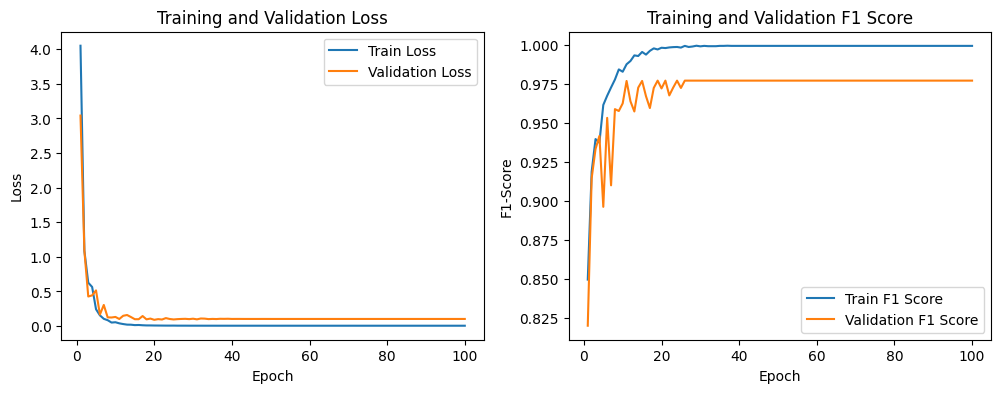

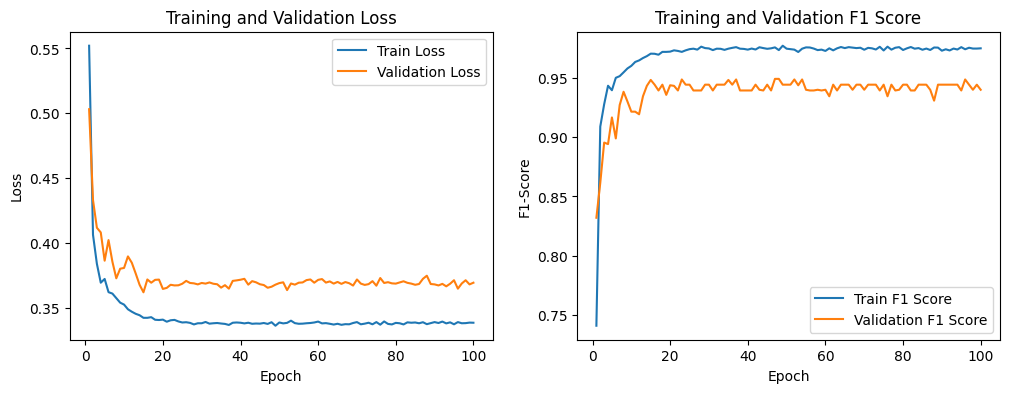

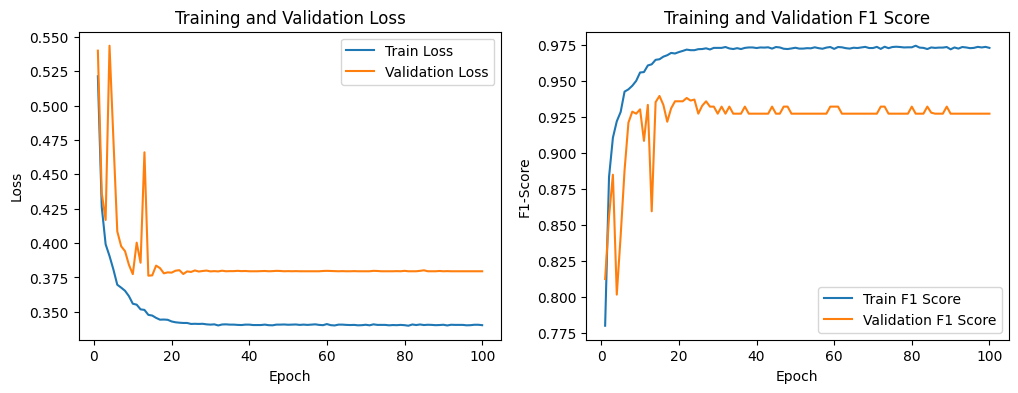

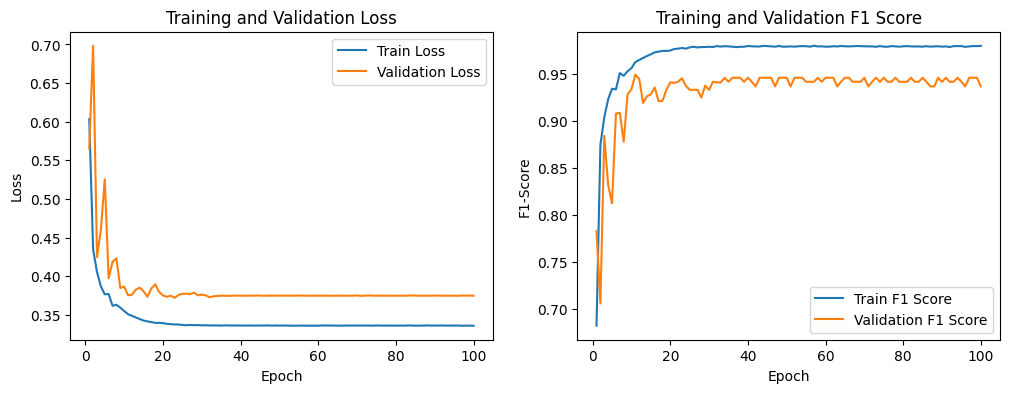

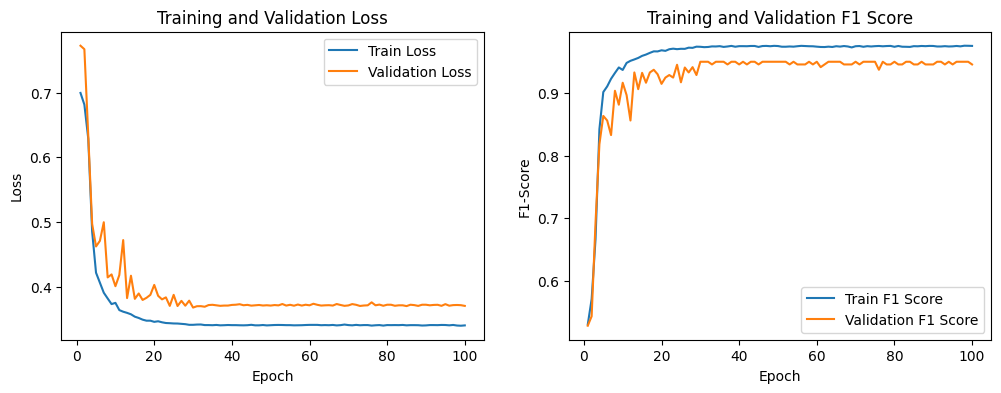

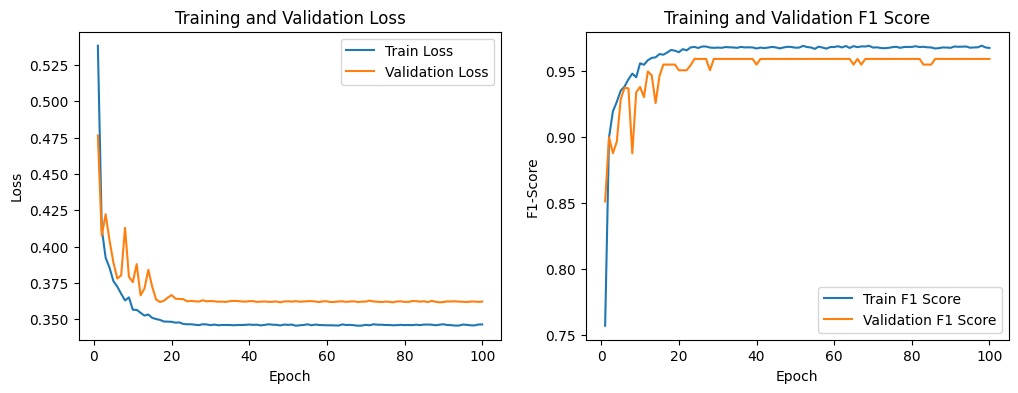

In [105]:
from torchmetrics import Recall, Precision, F1Score
import json


# Now the data is ready for training and validation

# Function to calculate relevant metrics

# Training function with Early Stopping
def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10):
    patience_counter = 0
    best_validation_f1 = 0
    best_validation_recall = 0
    best_validation_precision = 0
    train_losses = []
    train_f1s = []
    val_losses = []
    val_f1s = []
    val_recalls = []
    val_precisions = []
    recall_score_metric = Recall(task='binary')
    precision_score_metric = Precision(task='binary')
    f1_score_metric = F1Score(task='binary')
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
    for epoch in range(num_epochs):
        model.train()
        p_bar = tqdm(train_loader)
        running_loss = 0
        all_preds = []
        all_labels = []
        for i, (images, labels) in enumerate(p_bar):
            #if model_name == 'KAL_NET':
            #    images = images.view(-1, 224 * 224)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu())
            all_labels.extend(labels.cpu())
            p_bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {(running_loss / (i + 1)):.4f}")

        train_losses.append(round(running_loss / len(train_loader), 4))
        all_preds = torch.tensor(all_preds, dtype=torch.float32)
        all_labels = torch.tensor(all_labels, dtype=torch.long)
        train_f1s.append(round(f1_score_metric(all_labels, all_preds).item(), 4))

        if (epoch + 1) % 1 == 0:
            model.eval()
            p_bar = tqdm(val_loader)
            all_preds = []
            all_labels = []
            with torch.no_grad():
                running_loss = 0
                for i, (images, labels) in enumerate(p_bar):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu())
                    all_labels.extend(labels.cpu())
                    p_bar.set_description(f'Epoch {epoch+1}/{num_epochs} - Validation Batch: {i}')

                all_preds = torch.tensor(all_preds, dtype=torch.float32)
                all_labels = torch.tensor(all_labels, dtype=torch.long)
                precision = round(precision_score_metric(all_labels, all_preds).item(), 4)
                recall = round(recall_score_metric(all_labels, all_preds).item(), 4)
                f1 = round(2 * (precision * recall)/(precision + recall + 1e-10), 4)

                val_losses.append(round(running_loss / len(val_loader), 4))
                val_f1s.append(f1)
                val_recalls.append(recall )
                val_precisions.append(precision)

                print(f"Epoch {epoch+1}/{num_epochs} - Validation F1 Score: {f1:.4f} - Validation Recall Score: {recall:.4f} - Validation Precision Score: {precision:.4f}")
                if f1 > best_validation_f1:
                    best_validation_f1 = f1
                    best_validation_precision = precision
                    best_validation_recall = recall
                    patience_counter = 0
                    print('Exceeded')
                    #torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_results', 'best_model_resnet.pth'))

                else:
                    patience_counter += 1
            scheduler.step()
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
    return train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_validation_f1, best_validation_precision, best_validation_recall

out_dicts = {}
for i, (model, model_name) in enumerate(models):
    model = model([224*224, 224, 128, 2]).to(device)
    criterion = torch.nn.CrossEntropyLoss()  # For multi-class or binary classification
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)  # AdamW with L2 regularization
    print(f'Start training of: {model_name}')
    train_losses, train_f1s, val_losses, val_f1s, val_recalls, val_precisions, best_val_f1, best_val_precision, best_val_recall = train_model(model, model_name, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=100)

    # Start training
    print(f'Best F1: {best_val_f1}, Precision: {best_val_precision}, Recall: {best_val_recall}')
    #print('Val F1s', val_f1s)
    #print('Val Recalls: ', val_recalls)
    #print('Val Precisons: ', val_precisions)

    # Plot training and validation loss

    out_dict = {
        'train_losses': train_losses,
        'train_f1s': train_f1s,
        'val_losses': val_losses,
        'val_f1s': val_f1s,
        'val_recalls': val_recalls,
        'val_precisions': val_precisions,
        'best_val_f1': best_val_f1,
        'best_val_precision': best_val_precision,
        'best_val_recall': best_val_recall
    }
    out_dicts[model_name] = out_dict


    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_f1s) + 1), train_f1s, label='Train F1 Score')
    plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    #plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/model_results/{model_name}_F1.png')
    print('\n\n\n')

with open('/content/drive/MyDrive/model_results/results.json', 'w') as fp:
    json.dump(out_dicts, fp, indent=2)


In [106]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)

            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def test_model(model, test_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, test_loader, device)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

# Define and initialize your model using fast KAN
print(model_name)
test_model(model, test_loader, device)

NameError: name 'test_dataset' is not defined